# A few Things about Linear Concept Approximation

This Notebook is a part of the Thesis Project: Learning Multilingual Document Representations.
(Marc Lenz, 2021)


** **

## Linear Concept Approximation in General

**What is Linear Concept Approximation?**
- Method for Cross-Lingual information Retrieval. For two documents in different languages, lets say:
$d_{x=english},d_{y= french}$ we create vector representations $\bar{d_{x}} \in \mathbb{R}^{n} , \bar{d_{y} \in \mathbb{R}^{n_{x}}}$. Then we train a mapping from the english vector represenations to the french, $\theta: \mathbb{R}^{n}\rightarrow \mathbb{R}^{n}$. Where $ cos(\theta(\bar{d_{x=english}}), \bar{d_{y_french}})$ will give a good similarity measure.

**How is it computed?**

Given two sets of aligned documents $D_{x},D_{y}$ of two different Languages $L_{x}, L_{y}$,
we first create the Bag of Words (BOW) of each document for their respective language. 
This yields two sets of high-dimensional vectors. We convert these into matrices: $X\in \mathbb{R}^{n_{x}},Y\in \mathbb{R}^{n_{y}}$. Where the ith column of X,Y is the ith BOW vector of $d_{x,i}$
Followed by that we compute the r-truncted singular value decomposition of X and Y:
$X_{*k} = U \Sigma V_{*k}$ , same for Y.

Then, in the second step we want to find a mapping $\theta: X_{*k} \rightarrow Y_{*k}$, $\theta$ linear.
We use the least square loss $||X\theta-Y||_{2}^{2}$

##  1. Create the LSI Models/SVD for Preprocessed Data

The original JRC-Arquis dataset have been preprocessed before. 
The aligned documents have been saved in two seperate csv files. 
For details of the preprocessing, check: read_and_preprocess.py

In [1]:
from Utils import read_docs
from sklearn.model_selection import train_test_split

# parse an xml file by name
french_docs, english_docs = read_docs('Data/jrq_aligned_10000_fr.csv', 'Data/jrq_aligned_10000_en.csv')
fr_docs_train, fr_docs_test, en_docs_train, en_docs_test = train_test_split(french_docs, english_docs, 
                                                                            test_size=0.1, random_state = 42)

print("Number of training Documents: "+ str(len(fr_docs_train)))
print("Number of test Documents: "+ str(len(fr_docs_test)))

Number of training Documents: 8759
Number of test Documents: 974


In [63]:
from Utils import Vector_Lsi_Model

max_dim = 1500
lsi_model_fr = Vector_Lsi_Model(french_docs, dimension = max_dim)
lsi_model_en = Vector_Lsi_Model(english_docs, dimension = max_dim)



## Create Vector Representations

In [64]:

env = lsi_model_en.create_embeddings(en_docs_train)
frv = lsi_model_fr.create_embeddings(fr_docs_train)

In [65]:
envt = lsi_model_en.create_embeddings(en_docs_test)
frvt = lsi_model_fr.create_embeddings(fr_docs_test)

In [66]:
import numpy as np
en_train_matrix = np.asarray(env)
fr_train_matrix = np.asarray(frv)
en_test_matrix = np.asarray(envt)
fr_test_matrix = np.asarray(frvt)

## 2.Training of Linear Concept Approximation

In [247]:
from Utils import mate_retrieval_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from tqdm import tqdm

sample_sizes = [100, 200, 300, 500, 800, 1200, 2000, 4000, 6000, 8000, 10000]#, 900, 1300, 1800, 2500, 3500, 5000, 8000]
dimensions = [100, 300, 600, 900, 1200, 1500]

scores = []
losses = []
for dimension in tqdm(dimensions):
    s_scores = []
    s_losses = []
    for sample_size in sample_sizes:
        l1_to_l2_clf = linear_model.Ridge(alpha = 0)
        l2_to_l1_clf = linear_model.Ridge(alpha = 0) 
        
        l1_to_l2_clf.fit(list(en_train_matrix[:sample_size ,:dimension]), list(fr_train_matrix[:sample_size ,:dimension]))
        l2_to_l1_clf.fit(list(fr_train_matrix[:sample_size ,:dimension]), list(en_train_matrix[:sample_size ,:dimension]))  
        
        fake_fr = l1_to_l2_clf.predict(list(en_test_matrix[: ,:dimension]))
        fake_en = l2_to_l1_clf.predict(list(fr_test_matrix[: ,:dimension]))
        
        merged_trans_vecs = np.concatenate((fake_en, fr_test_matrix[:,:dimension]), axis = 1)
        real_vecs = np.concatenate((en_test_matrix[:,:dimension], fake_fr), axis = 1)
        
        score = mate_retrieval_score(merged_trans_vecs, real_vecs)
        loss = mse(merged_trans_vecs, real_vecs)
        s_losses.append(loss)
        s_scores.append(score)
        
    scores.append(s_scores)
    losses.append(s_losses)

  0%|                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.86601e-18): result may not be accurate.
  overwrite_a=True).T
 17%|███████████▎                                                        | 1/6 [00:02<00:10,  2.17s/it]C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix

C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.84456e-19): result may not be accurate.
  overwrite_a=False)
C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.49195e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.76892e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.94174e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\Gebruiker\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.40535e-18): result may not be accurate.
  overwrite_a=False)
C:\Users\Gebruiker\Anaconda3\lib\site-package

**-> For some Values, the problem seems to be ill-conditioned**

**-> That is also visible in the plots below**

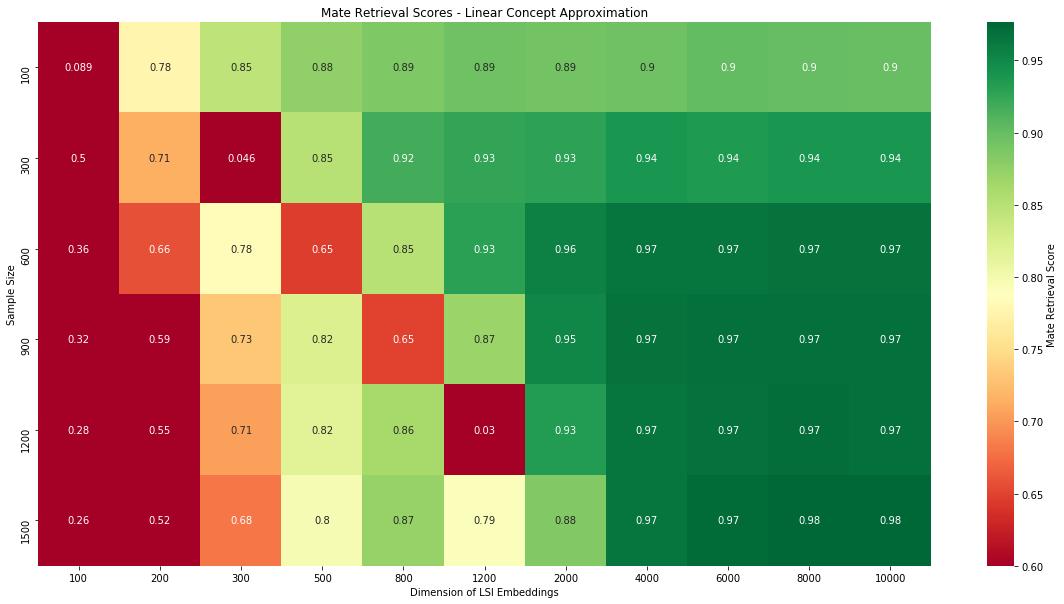

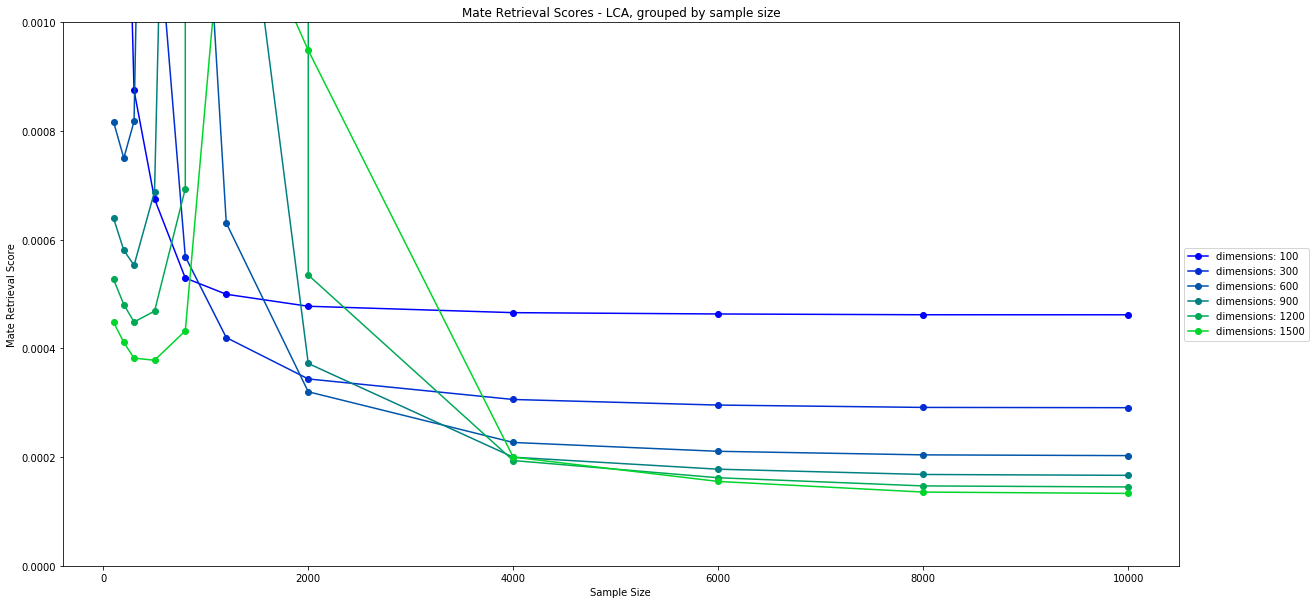

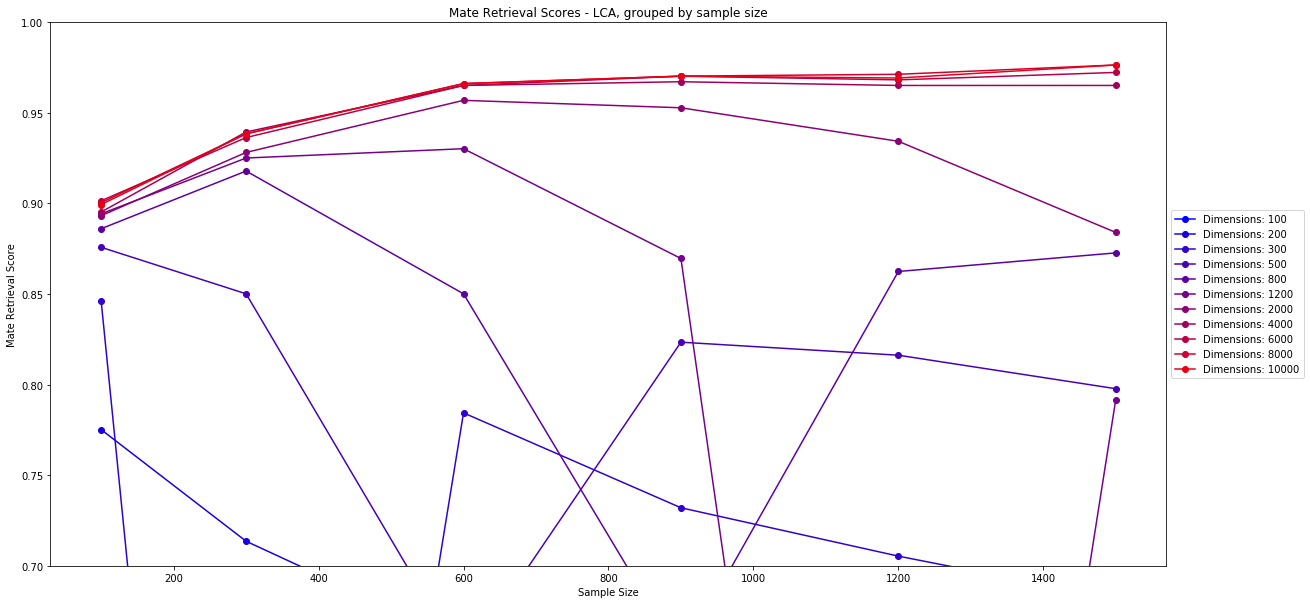

In [251]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

score_matrix = np.asarray(scores)
plt.figure(figsize=(20,10))
ax = sns.heatmap(score_matrix, vmin=0.6,
                 yticklabels=dimensions, 
                 xticklabels=sample_sizes,
                 cmap="RdYlGn", 
                 cbar_kws={'label': 'Mate Retrieval Score', 'orientation': 'vertical'},
                 annot=True
                )

plt.title("Mate Retrieval Scores - Linear Concept Approximation") 
plt.ylabel("Sample Size") 
plt.xlabel("Dimension of LSI Embeddings") 
plt.show()


loss_matrix = np.asarray(losses)
plt.figure(figsize=(20,10))
for k in range(len(dimensions)):
    b_val = k/len(dimensions)
    color = (0, b_val , 1 - b_val)
    plt.plot(sample_sizes, loss_matrix[k,:],"-o", label="dimensions: "+str(dimensions[k]), c=color)

plt.title("Mate Retrieval Scores - LCA, grouped by sample size")
plt.xlabel("Sample Size")
plt.ylabel("Mate Retrieval Score")
plt.ylim((0,0.001))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


plt.figure(figsize=(20,10))
for k in range(len(sample_sizes)):
    b_val = k/len(sample_sizes)
    color = (b_val, 0 , 1 - b_val)
    plt.plot(dimensions, score_matrix[:,k],"-o", label="Dimensions: "+str(sample_sizes[k]), c = color)

plt.title("Mate Retrieval Scores - LCA, grouped by sample size")
plt.xlabel("Sample Size")
plt.ylabel("Mate Retrieval Score")
plt.ylim((0.7,1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 3.Training of Linear Concept Approximation with Regularization 

Adding a small regularization term to the linear regression can improve the 

conditioning of the problem -> https://en.wikipedia.org/wiki/Tikhonov_regularization

In [241]:
from Utils import mate_retrieval_score
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from tqdm import tqdm

sample_sizes = [100, 200, 300, 500, 800, 1200, 2000, 4000, 6000, 8000, 10000]#, 900, 1300, 1800, 2500, 3500, 5000, 8000]
dimensions = [100, 300, 600, 900, 1200, 1500]

scores = []
losses = []
for dimension in tqdm(dimensions):
    s_scores = []
    s_losses = []
    for sample_size in sample_sizes:
        l1_to_l2_clf = linear_model.Ridge(alphas=[1e-3, 1e-2, 1e-1, 1])
        l2_to_l1_clf = linear_model.Ridge(alphas=[1e-3, 1e-2, 1e-1, 1]) 
        
        l1_to_l2_clf.fit(list(en_train_matrix[:sample_size ,:dimension]), list(fr_train_matrix[:sample_size ,:dimension]))
        l2_to_l1_clf.fit(list(fr_train_matrix[:sample_size ,:dimension]), list(en_train_matrix[:sample_size ,:dimension]))  
        
        fake_fr = l1_to_l2_clf.predict(list(en_test_matrix[: ,:dimension]))
        fake_en = l2_to_l1_clf.predict(list(fr_test_matrix[: ,:dimension]))
        
        merged_trans_vecs = np.concatenate((fake_en, fr_test_matrix[:,:dimension]), axis = 1)
        real_vecs = np.concatenate((en_test_matrix[:,:dimension], fake_fr), axis = 1)
        
        score = mate_retrieval_score(merged_trans_vecs, real_vecs)
        loss = mse(merged_trans_vecs, real_vecs)
        s_losses.append(loss)
        s_scores.append(score)
        
    scores.append(s_scores)
    losses.append(s_losses)

100%|████████████████████████████████████████████████████████████████████| 6/6 [04:48<00:00, 48.16s/it]


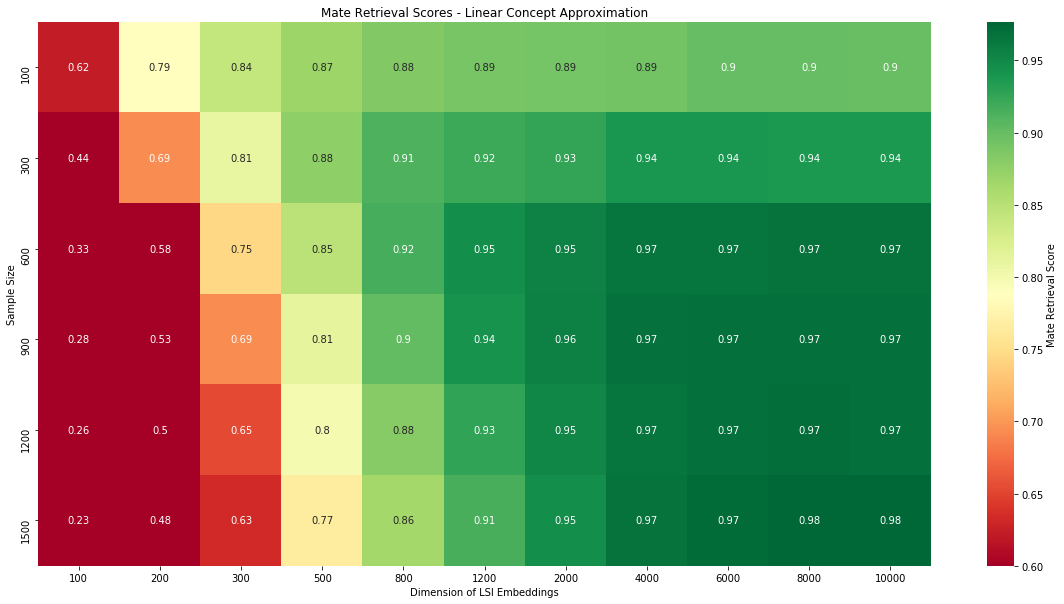

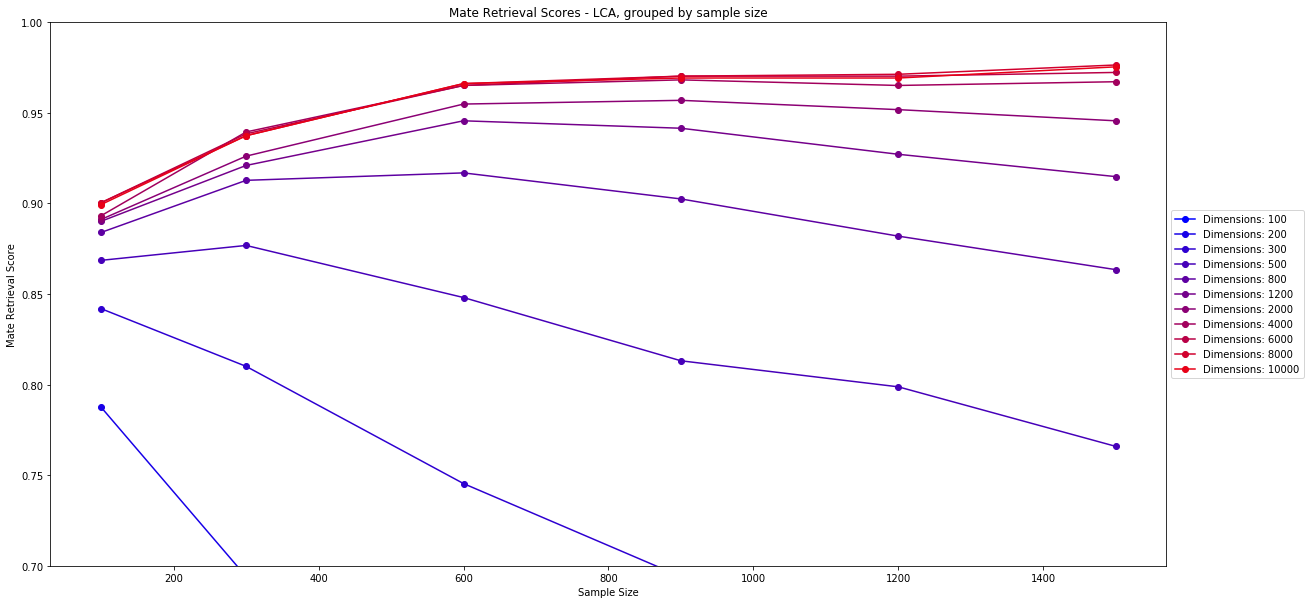

In [246]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

score_matrix = np.asarray(scores)
plt.figure(figsize=(20,10))
ax = sns.heatmap(score_matrix, vmin=0.6,
                 yticklabels=dimensions, 
                 xticklabels=sample_sizes,
                 cmap="RdYlGn", 
                 cbar_kws={'label': 'Mate Retrieval Score', 'orientation': 'vertical'},
                 annot=True
                )

plt.title("Mate Retrieval Scores - Linear Concept Approximation") 
plt.ylabel("Sample Size") 
plt.xlabel("Dimension of LSI Embeddings") 
plt.show()

plt.figure(figsize=(20,10))
for k in range(len(sample_sizes)):
    b_val = k/len(sample_sizes)
    color = (b_val, 0 , 1 - b_val)
    plt.plot(dimensions, score_matrix[:,k],"-o", label="Dimensions: "+str(sample_sizes[k]), c = color)

plt.title("Mate Retrieval Scores - LCA, grouped by sample size")
plt.xlabel("Sample Size")
plt.ylabel("Mate Retrieval Score")
plt.ylim((0.7,1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


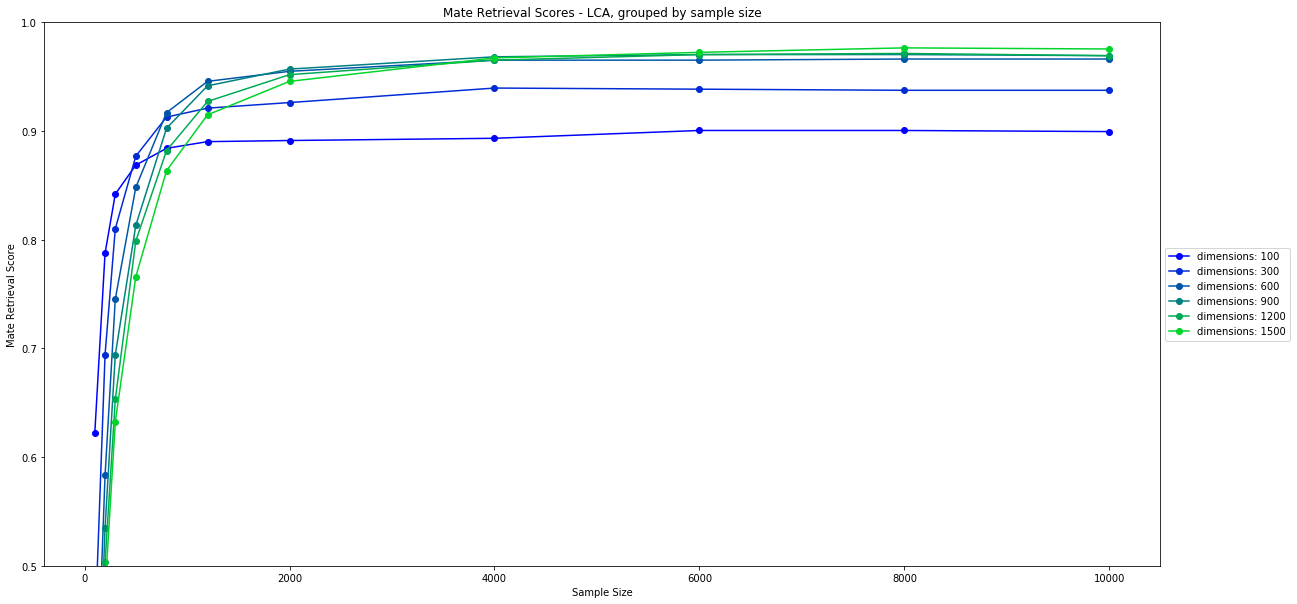

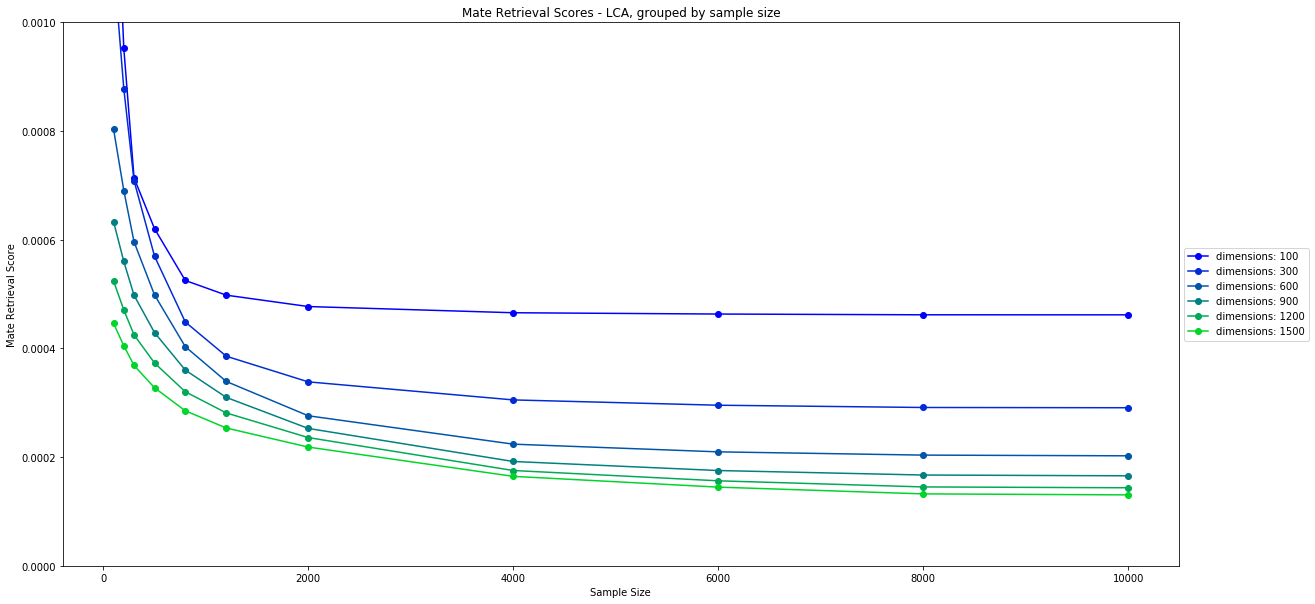

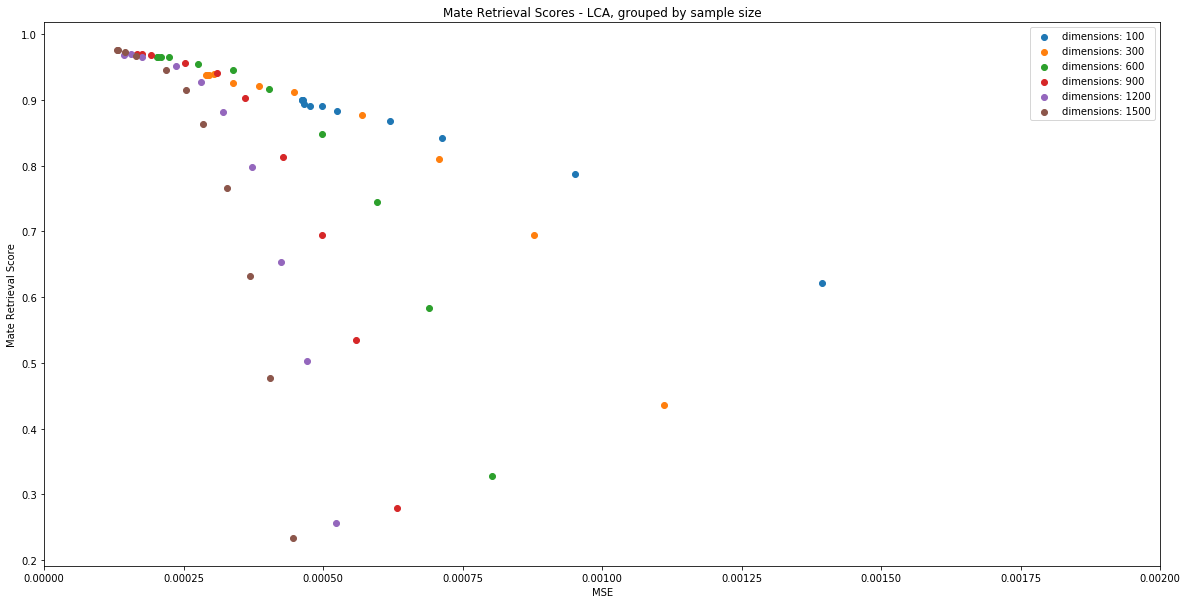

In [243]:
import matplotlib.pyplot as plt
score_matrix = np.asarray(scores)
plt.figure(figsize=(20,10))
for k in range(len(dimensions)):
    b_val = k/len(dimensions)
    color = (0, b_val , 1 - b_val)
    plt.plot(sample_sizes, score_matrix[k,:],"-o", label="dimensions: "+str(dimensions[k]), c=color)

plt.title("Mate Retrieval Scores - LCA, grouped by sample size")
plt.xlabel("Sample Size")
plt.ylabel("Mate Retrieval Score")
plt.ylim((0.5,1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

import matplotlib.pyplot as plt
score_matrix = np.asarray(losses)
plt.figure(figsize=(20,10))
for k in range(len(dimensions)):
    b_val = k/len(dimensions)
    color = (0, b_val , 1 - b_val)
    plt.plot(sample_sizes, score_matrix[k,:],"-o", label="dimensions: "+str(dimensions[k]), c=color)

plt.title("Mate Retrieval Scores - LCA, grouped by sample size")
plt.xlabel("Sample Size")
plt.ylabel("Mate Retrieval Score")
plt.ylim((0,0.001))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


import matplotlib.pyplot as plt
loss_matrix = np.asarray(losses)
score_matrix = np.asarray(scores)
plt.figure(figsize=(20,10))
for k in range(len(dimensions)):
    lossin = list(loss_matrix[k,:])
    scorin = list(score_matrix[k,:])
    
    sort_lossin = [x for _,x in sorted(zip(sample_sizes, lossin))]
    sort_scorin = [x for _,x in sorted(zip(sample_sizes, scorin))]
    
    plt.scatter(sort_lossin, sort_scorin, label="dimensions: "+str(dimensions[k]))

plt.title("Mate Retrieval Scores - LCA, grouped by sample size")
plt.xlabel("MSE")
plt.ylabel("Mate Retrieval Score")
#plt.ylim((0.5,1))
plt.xlim((0,0.002))
plt.legend()
plt.show()

## Observation:
- OLS can be ill-conditioned.
- Adding a regularization can help the conditioning while maintaining good results.

$\mathbb{E}[L(\hat{\theta})-L(\theta^{*})]$

## Linear Concept Approximation from the viewpoint of Statistical Learning Theory

- **Essential Question: If we know $X,Y$, can we make a good decision on how to choose the dimensionality k?**

Even without knowing the distribution of variables, statistical learning theory allows some statements about the expected behaviour of learning algorithms. Sometimes it can be utilized to choose parameters. 

**Truncated Singular Value Decomposition and the Eckardt Young Theorem:**, the following holds:
for $n\geq r$ and $X\in \mathbb{R}^{n \times n}$

$argmin_{\bar{X}: rank(\bar{X})=d}||X-\bar{X_{|d}}||_{2}= U \Sigma V_{*d}$

- In general: larger d $\implies$ better matrix approximation

For the loss we have $||X-\bar{X_{|d}}||_{2}= \sum_{k=1}^{n} \sigma_{k} - \sum_{k=1}^{d} \sigma_{k} = \sum_{k=d+1}^{n} \sigma_{k} $

Furthermore: $Var(X_{|d}) = Var(U \Sigma V_{*d}) = Var(\Sigma_{|d})=\sum_{k=1}^{d} \sigma_{k}$

**Linear Regression:**
- $\hat{\theta} = \frac{1}{n}[X \theta - Y]_{2}^{2}$
- Following a proof from https://web.stanford.edu/class/cs229t/notes.pdf, the following holds:
$\mathbb{E}[L(\hat{\theta})-L(\theta^{*})]= \frac{d\sigma^{2}}{n}$

So in this context, that means: $\mathbb{E}[L(\hat{\theta})-L(\theta^{*})] \leq \frac{d}{n^{2}}\sum_{k=1}^{d} \sigma_{k}$

**The Resulting conflict: How to scale d?**

So we have to balance: 
- the d-rank approximation loss $||X-\bar{X_{|d}}||_{2}=  \sum_{k=d+1}^{n} \sigma_{k} $
- the the expected excess loss $\mathbb{E}[L(\hat{\theta})-L(\theta^{*})] \leq \frac{d}{n^{2}}\sum_{k=1}^{d} \sigma_{k}$


**Asymptotical Perspective**

Ensure the convergence of the excess loss by using an upper bound. One approach would be to choose max $d(n)$ such that $\frac{d(n)}{n^{2}}\sum_{k=1}^{d(n)} \sigma_{k} \rightarrow 0$ for $n \rightarrow \infty$. 

Since the singular values are ordered descendingly, meaning that $\sigma_{1} \geq \sigma_{2}, \dots  \sigma_{k}$,
It is $\sum_{k=1}^{d(n)} \sigma_{k} \leq d(n)\sigma_{1}$ 

$ \implies \mathbb{E}[L(\hat{\theta})-L(\theta^{*})] \leq (\frac {d(n)} {n})^{2}\sigma_{1} $. 

So, we can make sure to fulfill the above condition, if we choose $d(n)$ such that:
- $(\frac {d(n)} {n})^{2}  \rightarrow 0$ For $n \rightarrow \infty$



# A Practical Suggestion

- Train the model for a given $N_{0},d_{0}$, take the generalization error $\epsilon_{0}$ as estimate of $\mathbb{E}[L(\hat{\theta_{|N_{0}}})-L(\theta^{*})]$.
- Idea: If we have $N_{0},d_{0},\epsilon_{0}$ define a function $\phi(k)$, such that for $N+k$ and $d+\phi(k)$ we can expect a smaller error.
- We can ensure this if $(\frac {d_{0}} {N_{0}})^{2}\sigma_{1} \leq (\frac {(d_{0}+\phi(k))} {N_{0}+ k})^{2}\sigma_{1}$ for k>1

Solve this by 
- setting $\frac {d_{0}^{2}} {N_{0}^{2}} = \frac {(d_{0}+\phi(k))^{2}} {(N_{0}+ k)^{2}}$ Which yields $\phi(k)  = \frac{d_{0}} {N_{0}} k$.

If we want the error furthermore to decrease with growing n, we can multiply it with a monotonically decreasing function, with limes 0. The suggestion is to choose: 

- $\gamma(k) := \frac{d_{0}} {N_{0}} \frac{k} {o(k)}$, with $o(1)>1$, $o(k)$ monotonically increasing and $o(n)\rightarrow 0$ for $n\rightarrow \infty$.

- So if for $N_{0},d_{0}$, the expected error is $\epsilon_{0}$, for $N_{0}+k,d_{0}+\gamma(k)$ it will be $\frac{\epsilon_{0}}{o(k)}$. 

- Then we obtain $\bar{k} \geq k \implies \frac{\epsilon_{0}}{o(k)} \geq \frac{\epsilon_{0}}{o(\bar{k})}$ and $\frac{\epsilon_{0}}{o(k)} \rightarrow 0 ,k \rightarrow \infty $

Possible choice:
-  $o(x) = log_{b}(x+b)$, where b denotes the base

Leading to: 
- $\gamma(x) = \frac {d_{0}} {N_{0}} \frac {x}{log_{b}(x+b)}$, 

- The question is: Given the Variance and Sample size, can we choose the dimension optimally?